In [1]:
%matplotlib inline
from utils import *

## Neuron params

In [2]:
# Default params
R_m = 142 * 1e6                                     # 142 MΩ
V_th = 15 * 1e-3                                    # 15 mV
tau_m = 24 * 1e-3                                   # 24 ms
f = 5                                               # 5 Hz
omega = 2 * np.pi * f                               # 5 Hz in rad/s
I_osc = 40 * 1e-12                                  # 40 pA
M = 5                                               # number of input levels
range_frac = 0.75                                   # fraction of range to use
sigma_w_avg = 0.0135                                # average sigma_w
eta = sigma_w_to_eta(sigma_w_avg, V_th, tau_m, f)   # noise strength (default: 0.14)

## Simulation params

In [9]:
# Change some params
f = 5.                       # Hz
eta = 0.05 #0.11             # a.u.

# Simulation parameters
dt = 1e-4                    # Time step for numerical integration
t_end = 2 / f                # Duration of one cycle
t = np.arange(0, t_end, dt)
num_trials = 10000            # Number of trials

In [10]:
# Run the simulation and store voltage trajectories
all_res = get_distr_empirical(R_m, V_th, eta, tau_m, I_osc, f, M, dt, t, num_trials, range_frac, store_trajectories=True)
means, variances, all_phis, Is_range, all_voltages, all_first_spike_times, all_phi_0 = all_res

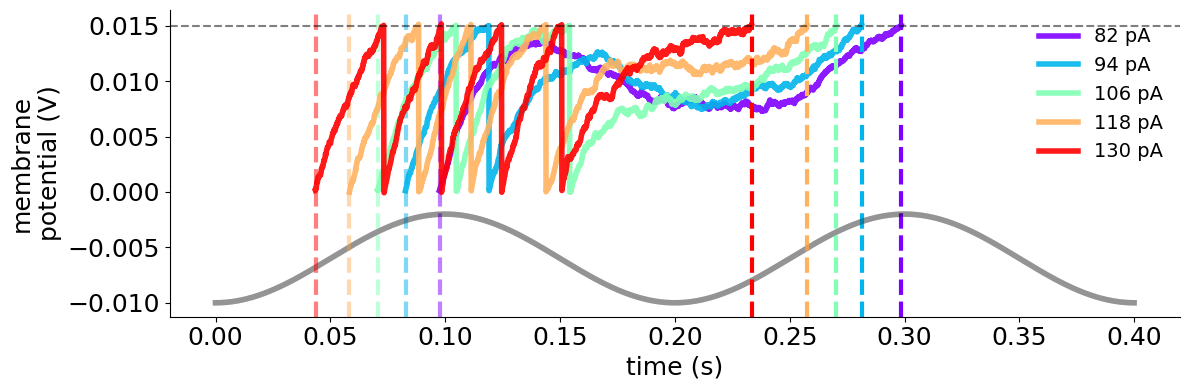

In [11]:
# Plot voltage trajectories with respect to oscillation I_theta
plt.figure(figsize=(12, 4))

c = cm.rainbow(np.linspace(0, 1, M))

for i, (voltage_trajectory, first_spike_times, phi_0) in enumerate(zip(all_voltages, all_first_spike_times, all_phi_0)):
    neuron_index = 0  # Choosing the first neuron as an example
    #t_temp = np.roll(t, -int(phi_0/(2*np.pi*f)/dt))
    shift = -int(phi_0 / (2 * np.pi * f) / dt)
    t_temp = roll_with_nan(t, shift)
    plt.plot(t_temp, voltage_trajectory[:, neuron_index], label=f'{Is_range[i]*1e12:.0f} pA', color=c[i], alpha=0.9, linewidth=4)
    plt.plot(t, I_osc * np.cos(2 * np.pi * f * t - np.pi) * 1e8 - 0.006, '-', color='k', alpha=0.1, linewidth=4)
    spike_time = first_spike_times[neuron_index] + phi_0/(2*np.pi*f)
    if not np.isnan(spike_time):
        plt.axvline(spike_time, color=c[i], linestyle='--', linewidth=3, alpha=1)
    plt.axvline(phi_0/(2*np.pi*f), color=c[i], linestyle='--', linewidth=3, alpha=0.5)

plt.axhline(V_th, color='k', linestyle='--', alpha=0.5)

plt.xlabel('time (s)', fontsize=18)
plt.ylabel('membrane\npotential (V)', fontsize=18)
plt.legend(loc='upper right', frameon=False, fontsize=14)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

sb.despine()
plt.tight_layout()
plt.show()

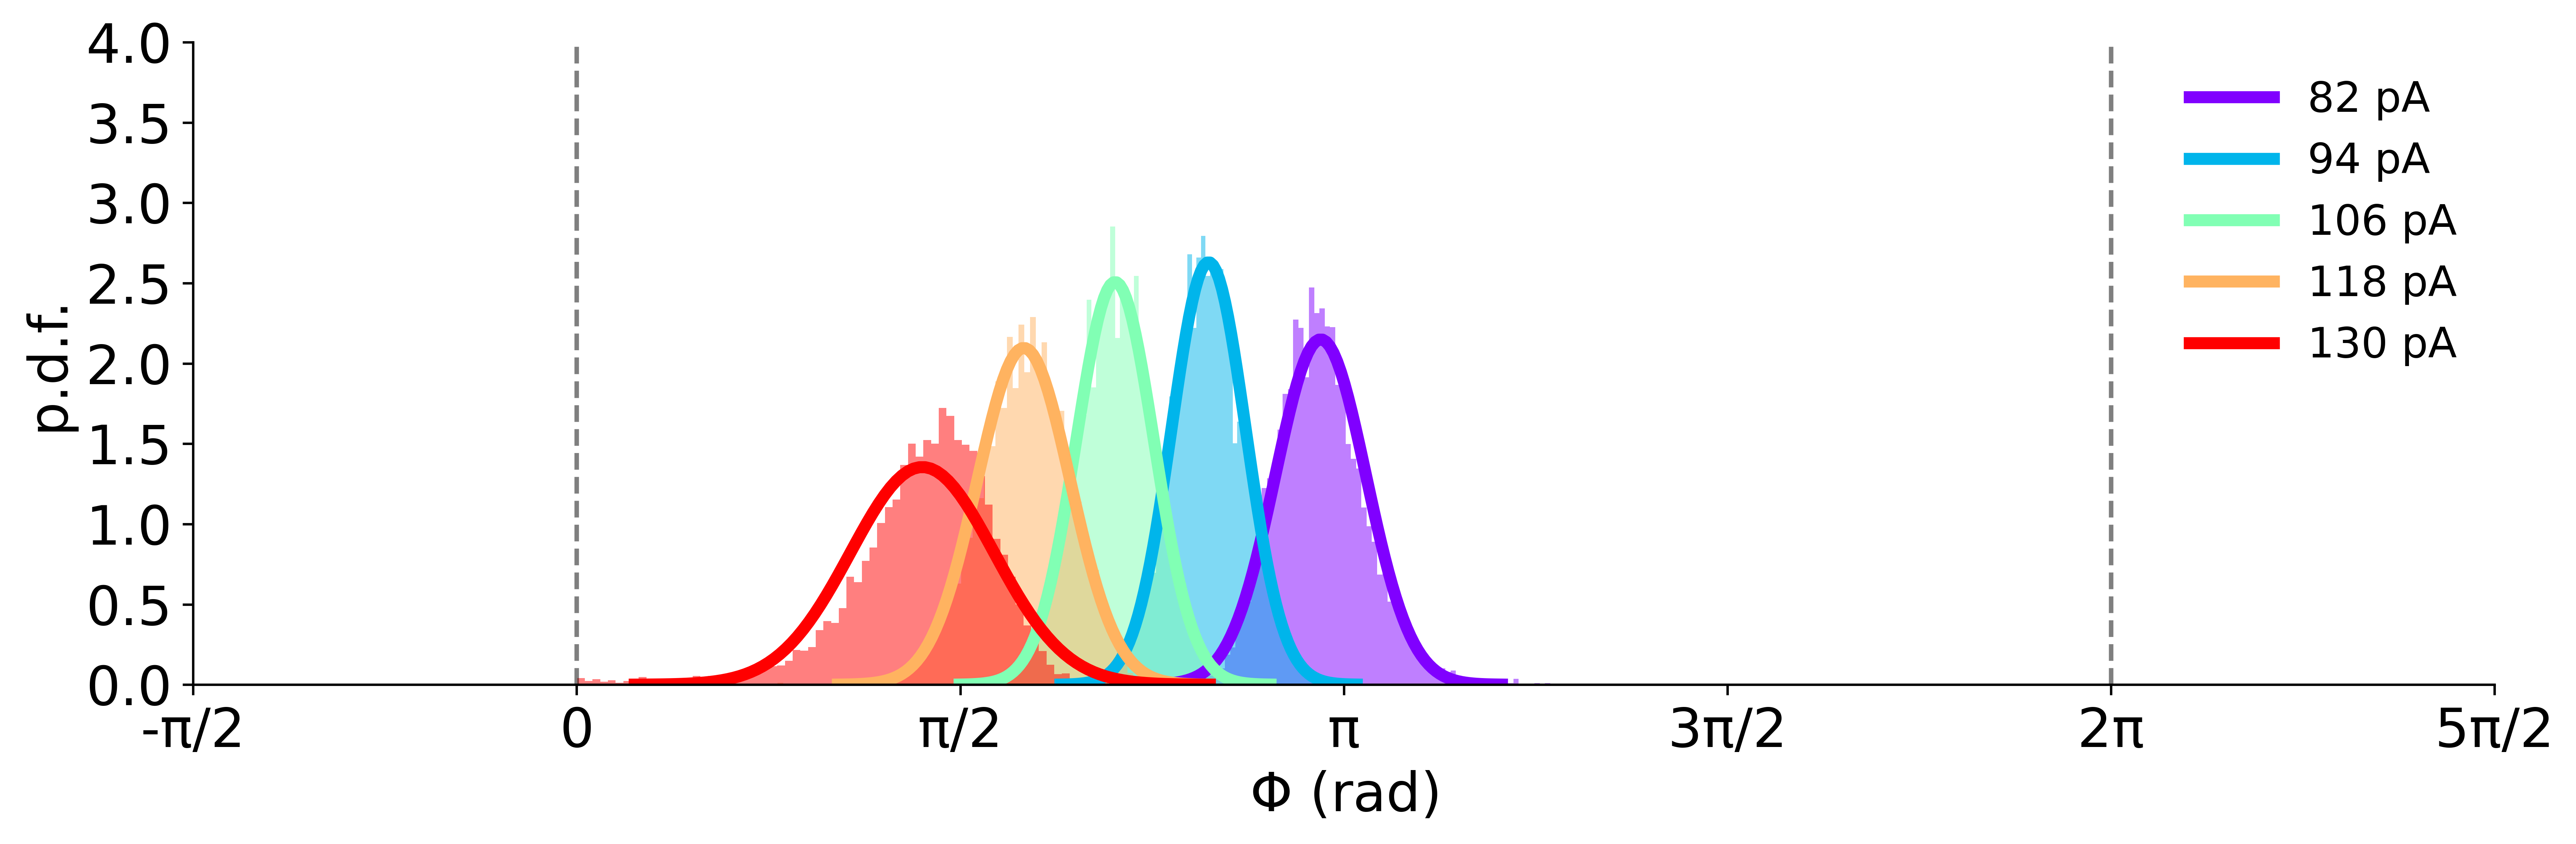

In [16]:
# Plotting the results
plt.figure(figsize=(12, 4), dpi=600)

alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='-', color=c[i], label=str(int(np.around(Is*1e12)))+" pA")
    plt.hist(all_phis[i], bins='auto', density=True, color=c[i], alpha=.5)

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f.', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=18)
plt.xlim(-np.pi/2, (5/2)*np.pi)
plt.ylim(0, 4)
plt.yticks(fontsize=18)

plt.axvline(0, linestyle='--', color='k', alpha=0.5)
plt.axvline(2 * np.pi, linestyle='--', color='k', alpha=0.5)

sb.despine()
plt.tight_layout()
plt.show()